1. linreg for EGTM, 1 engine only
2. tune theta degree
3. tune altitude + bleed ensemble

In [1]:
from deltas import *

bdu_all = pd.read_csv('./takeoff-merged-VQ-BDU-30s.csv', parse_dates=['reportts']).query('pos == 2')
bdu_all = correct(bdu_all)

Setup the experiment:

### 1. Gridsearch of x/y/theta variants

In [2]:
best_rmse = 1000
best_model = None
best_pred = None
best_x, best_y, best_th = None, None, None

alpha = 0.5
alpha_2 = 0.869

x_variants = [\
  'n1', 'n1a', 'n1com', 'n1c2', 'n2a', 'n2c5',
  'n2p', 'nf', 'n1_peak', 'n1msa', 'n1p',
  'n1a_peak', 'n1c2_peak', 'n1com_peak', 
  'n1max', 'n1max_peak', 'n2a_peak', 'nf_peak']

y_variants = ['egt', 'egt_peak', 'egtb']

theta_variants = ['oat', 'oat_peak', 't14', 't2', 't25', 't2_peak', 'tat', 'tat_rtd', 'tn', 'tat_peak']

hall_of_fame = []

tat_peak = правильный

In [3]:
def theta_correct(data, x_param, y_param, theta_param, alpha2 = alpha_2):
  theta = (data[theta_param] + 273.16) / 288.16
  data[f'{y_param}_k'] = (data[y_param] + 273.16) / (theta ** alpha2)
  data[f'{x_param}_k'] = data[x_param] / (theta ** alpha)
  return data

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

for x_param in x_variants:
  for y_param in y_variants:
    for theta_param in theta_variants:
      bdu = bdu_all.query(f"{x_param} > 0 and {y_param} > 0 and {theta_param} > -100 and egtm > -100").copy()
      x_param_k, y_param_k = f'{x_param}_k', f'{y_param}_k'
      bdu = theta_correct(bdu, x_param, y_param, theta_param)
      assert bdu.shape[0] >= 200
      baseline = train_engine_baseline(bdu[:200], x_param_k, y_param_k)
      egtm = compute_egtm(bdu, baseline, x_param_k, y_param_k)

      X = pd.DataFrame(smooth(egtm, 0.05))
      lin_model = LinearRegression()
      lin_model.fit(X, y=bdu['egtm'])

      pred = lin_model.predict(X)
      
      rmse = root_mean_squared_error(bdu['egtm'], pred)

      if rmse < best_rmse:
        best_pred = pred
        best_rmse = rmse
        best_model = lin_model
        best_x, best_y, best_th = x_param, y_param, theta_param

      hall_of_fame.append({
        'x_param': x_param,
        'y_param': y_param, 
        'theta_param': theta_param,
        'rmse': rmse
      })


In [5]:
pd.DataFrame(hall_of_fame).sort_values('rmse')[:10]

,x_param,y_param,theta_param,rmse
496,n2a_peak,egt_peak,tat,0.854380
491,n2a_peak,egt_peak,oat_peak,0.896620
499,n2a_peak,egt_peak,tat_peak,0.898597
495,n2a_peak,egt_peak,t2_peak,0.922984
492,n2a_peak,egt_peak,t14,0.933362
121,n2a,egt,oat_peak,1.150380
129,n2a,egt,tat_peak,1.152122
125,n2a,egt,t2_peak,1.173272
122,n2a,egt,t14,1.198499
126,n2a,egt,tat,1.211525


#### Plot best result: 

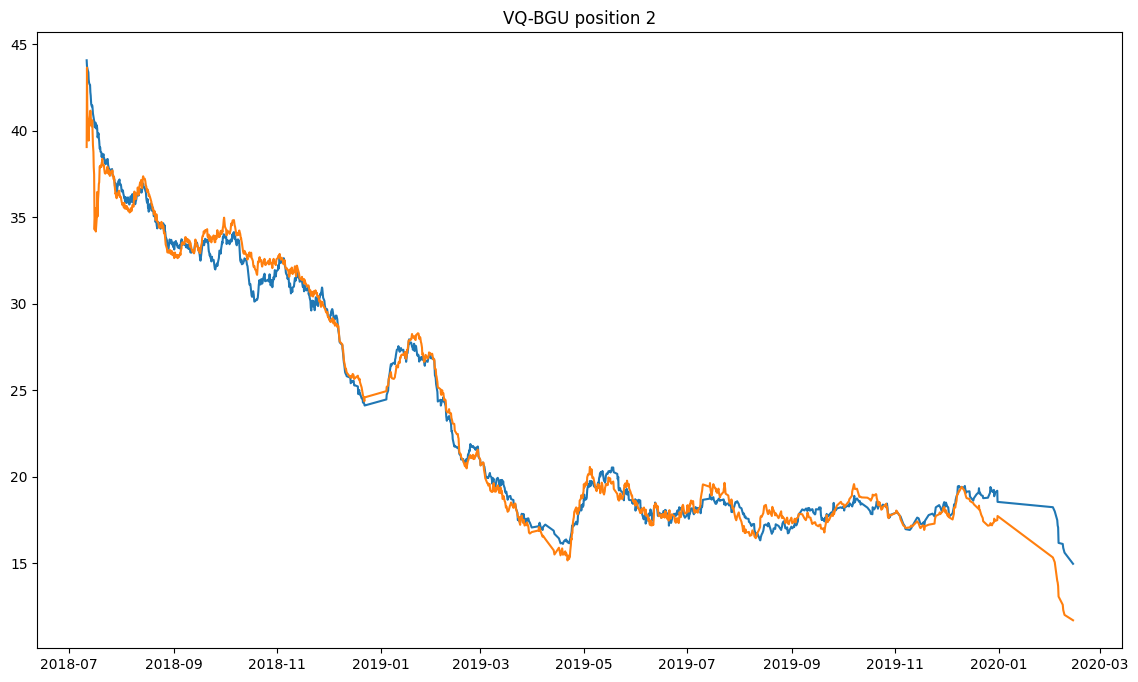

In [6]:
import matplotlib.pyplot as plt

bdu = bdu_all.query(f"n2a_peak > 0 and egt_peak > 0 and tat > -100 and egtm > -100").copy()

plt.figure(figsize=(14, 8))
plt.title(f'VQ-BGU position 2')
plt.plot(bdu['reportts'], best_pred)
plt.plot(bdu['reportts'], bdu['egtm'])
plt.show()

### Finetune coefficient for theta corrections

In [7]:
best_x, best_y, best_th

('n2a_peak', 'egt_peak', 'tat')

In [8]:
best_rmse = 1000
best_a = 1000

factor = 10_000

for a in range(8000, 9000, 1):
  bdu = theta_correct(bdu, best_x, best_y, best_th, alpha2=(a / factor))
  x_param_k, y_param_k = f'{best_x}_k', f'{best_y}_k'
  baseline = train_engine_baseline(bdu[:200], x_param_k, y_param_k)
  egtm = compute_egtm(bdu, baseline, x_param_k, y_param_k)

  X = pd.DataFrame(smooth(egtm, 0.05))
  lin_model = LinearRegression()
  lin_model.fit(X, y=bdu['egtm'])

  pred = lin_model.predict(X)
  
  rmse = root_mean_squared_error(bdu['egtm'], pred)

  if rmse < best_rmse:
    best_a = a / factor
    best_rmse = rmse

print(best_a, best_rmse)

0.8692 0.8543621197141335


**Result For VQ-BDU pos 2:**

- `alpha_2 = 0.869 (not 0.84)`
- `x_param = n2a_peak`
- `y_param = egt_peak	`
- `theta_param = tat`

For VQ-BGU results are inconsistent; We try to plot deltas applying corrections same as for VQ-BDU

In [9]:
bgu_all = pd.read_csv('./takeoff-merged-VQ-BGU-30s.csv', parse_dates=['reportts']) \
  .query('pos == 2 and reportts >= "2019-01-01"')
bgu_all.shape

(814, 212)

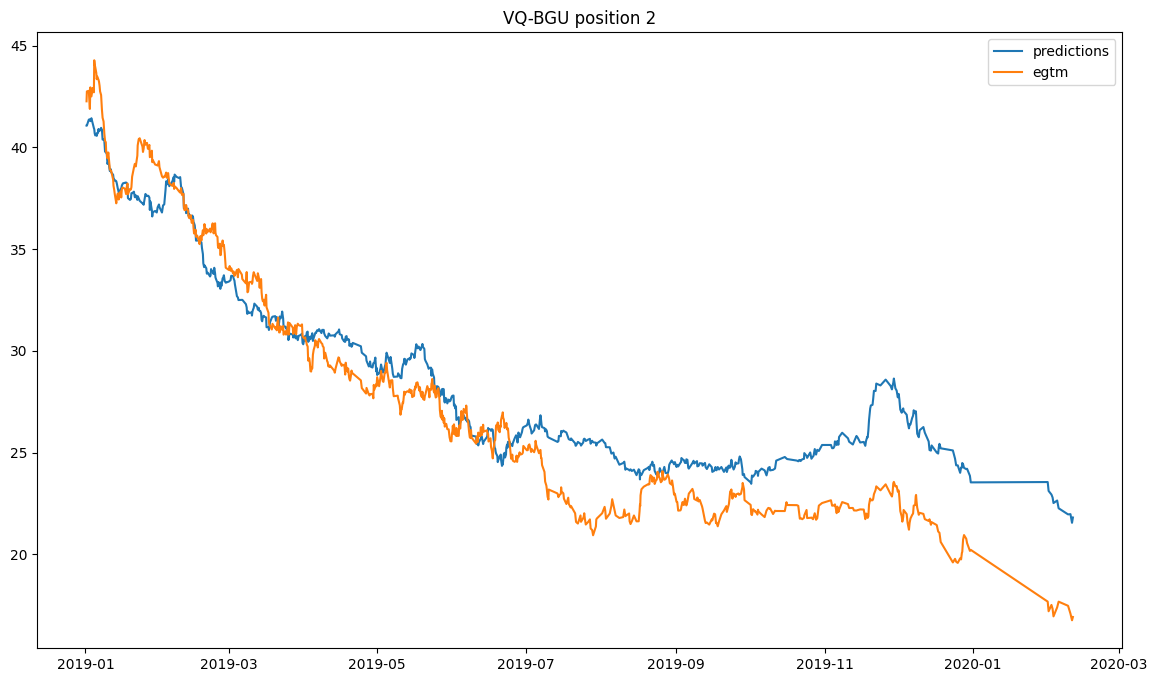

In [10]:
x_param = "n2a_peak"
y_param = "egt_peak"
theta_param = "tat_peak"

bgu = bgu_all.query(f"{x_param} > 0 and {y_param} > 0 and {theta_param} > -100 and egtm > -100").copy()
x_param_k, y_param_k = f'{x_param}_k', f'{y_param}_k'
bgu = theta_correct(bgu, x_param, y_param, theta_param)
assert bgu.shape[0] >= 200
baseline = train_engine_baseline(bgu[:200], x_param_k, y_param_k)
egtm = compute_egtm(bgu, baseline, x_param_k, y_param_k)

X = pd.DataFrame(smooth(egtm, 0.05))
lin_model = LinearRegression()
lin_model.fit(X[:200], y=bgu['egtm'][:200])

pred = lin_model.predict(X)

rmse = root_mean_squared_error(bgu['egtm'], pred)

# bgu = bgu_all.query(f"n2a_peak > 0 and egt_peak > 0 and tat > -100 and egtm > -100").copy()

plt.figure(figsize=(14, 8))
plt.title(f'VQ-BGU position 2')
# plt.plot(bgu['reportts'], pred)
plt.plot(bgu['reportts'], smooth(0.8 * egtm + 7.4, 0.05))
plt.plot(bgu['reportts'], bgu['egtm'])
plt.legend(['predictions', 'egtm'])
plt.show()

In [12]:
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np

class CustomRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, parameter1=1, parameter2=2):
        self.parameter1 = parameter1
        self.parameter2 = parameter2
        # Initialize any other variables here
    
    def fit(self, X, y):
        # Training logic goes here
        # X is the array of features, y is the array of labels
        # Example:
        # self.coefficients = np.linalg.inv(X.T @ X) @ X.T @ y
        # Assuming X is a numpy array
        self.coefficients = np.linalg.inv(X.T @ X) @ X.T @ y
        return self
    
    def predict(self, X):
        # Prediction logic goes here
        # X is the array of features for which predictions are to be made
        # Example:
        # return X @ self.coefficients
        pass # Placeholder for actual implementation
    
    def score(self, X, y):
        # Evaluation logic goes here
        # X is the array of features, y is the array of true labels
        # Example:
        # predictions = self.predict(X)
        # return some_evaluation_metric(predictions, y)
        pass # Placeholder for actual implementation
